In [1]:
__author__ = 'Alex Drlica-Wagner, DES Collaboration'
__version__ = '20210330' # yyyymmdd
__datasets__ = ['des_dr1']  # enter used datasets by hand;
                           # for a list of available datasets, see cell "Available datasets in Data Lab" further below

# Stellar Streams with DES DR2

by [Alex Drlica-Wagner](https://github.com/kadrlica) (DES Collaboration)

The Dark Energy Survey (DES) is a ~600 night survey using the Dark Energy Camera (DECam; [Flaugher et al. 2015](https://arxiv.org/abs/1504.02900)) on the 4-meter Blanco telescope to observe ~5000 deg2 of the sky in the $grizY$ broad-band filters. The first data release, DES DR1 ([DES Collaboration, 2018]()), includes ~400 million astronomical sources, while the second release, DES DR2 ([DES Collaboration, 2021]()), includes ~700 millions astronomical sources. In this notebook, we demonstrate how to use the DES data to investigate stars around the globular cluster M79 (NGC 1904). We use the color-magnitude diagram of M79 to define a filter and apply that selection to extract the ATLAS stellar stream ([Koposov et al. 2014](https://arxiv.org/abs/1403.3409); [Shipp et al. 2018](https://arxiv.org/abs/1801.03097)).

NOAO Data Lab products and services used here:

* the DES DR2 database
* Jupyter Notebook Server
* Query Manager

Below, we query the database, compute colors, plot a few color combinations, select objects that are likely to be stars, and define a color-magnitude filter.

### Table of Contents

0. [Disclaimer & Attribution](#attribution)
1. [Imports and setup](#import)
2. [Authentication](#auth)
3. [Available Datasets in Data Lab](#datasets)
3. [Investigating the M79 Globular Cluster](#m79)
4. [Investigating the ATLAS Stellar Stream](#atlas)

<a class="anchor" id="attribution"></a>
# 0. Disclaimer & Attribution

If you use this notebook for your published science, please acknowledge the following:
* DES DR2: DES Collaboration "The Dark Energy Survey Data Release 2" [arxiv:21XX.XXXXX]()
* Shipp et al. "Stellar Streams Discovered in the Dark Energy Survey" ApJ, 862, 114, 2018, http://dx.doi.org/10.3847/1538-4357/aacdab
* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445
* Data Lab disclaimer: https://datalab.noao.edu/disclaimers.php

<a class="anchor" id="import"></a>
# 1. Imports and setup

In [2]:
# std lib
from getpass import getpass

# 3rd party
import pandas as pd
import numpy as np
import pylab as plt
import matplotlib
from astropy import utils, io, convolution, stats
from astropy.visualization import make_lupton_rgb
%matplotlib inline
from matplotlib.path import Path
from matplotlib.patches import PathPatch

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc, helpers

<a class="anchor" id="auth"></a>
# Authentication
The functionality in this notebook does not require authenticated access to Data Lab; authentication is only needed if access to the MyDB or VOSpace storage are desired. Should you want to authenticate, please un-comment in the cell below the line beginning with `#token =` and un the cell, following instructions to provide you Data Lab username and password. You only need to do this once (unless you log out through authClient), as the authentication token is stored on the server and automatically detected.

In [3]:
# As an anonymous user, you can issue queries to the database or retrieve image cutouts, but
# not store your results in virtual storage or myDB

# Get token for an authenticated user if you wish to use virtual storage or myDB
#token = ac.login(input("Enter user name: "),getpass("Enter password: "))
ac.whoAmI()

'robertdemo'

<a class="anchor" id="datasets"></a>
# 3. Available Datasets in Data Lab

In [4]:
# set default profile
qc.set_profile('default')

# these schemas are not astronomical datasets
_remove = set(['ivao','ivao_smash','tap_schema','schema'])

# get all schemas from DB
_schemas = set(qc.query(sql="SELECT schema FROM tbl_stat where schema like 'des_%'").split())

# remove non-astro schemas
_alldatasets = sorted(list(_schemas - _remove))
print("DES datasets available in Data Lab (with current profile):\n", _alldatasets)

# TODO: Enter used datasets by hand in the list __datasets__ in the very first cell above

DES datasets available in Data Lab (with current profile):
 ['des_dr1', 'des_dr2', 'des_sva1']


In [5]:
print(qc.schema('des_dr1',format='json'))


Schema: des_dr1

      Table Name   Description
      ----------   -----------
     des_allwise   ALLWISE 1-arcsec xmatch v. DES
       des_gaia2   Gaia DR2 1.5-arcsec xmatch v. DES
       des_galex   GALEX (AIS) 1-arcsec xmatch v. DES
        des_hsc2   HSC2 1-arcsec xmatch v. DES
      des_nscdr1   NSC DR1 1.5-arcsec xmatch v. DES
      des_simbad   SIMBAD 1-arcsec xmatch v. DES
            flux   Object flux table
        galaxies   
       img2coadd   Images contributing to coadded tiles
             mag   Object magnitude table
            main   Main object table
       neighbors   Neighbors w/in 30-arcsec of each object
       tile_info   Survey tile information table
x1p5__main__allwise__source   des_dr1.main and allwise.source crossmatch (1.5 arcsec)
x1p5__main__gaia_dr2__gaia_source   des_dr1.main and gaia_dr2.gaia_source crossmatch (1.5 arcsec)
x1p5__main__nsc_dr1__object   des_dr1.main and nsc_dr1.object crossmatch (1.5 arcsec)
x1p5__main__sdss_dr16__specobj   des_dr1.main

<a class="anchor" id="m79"></a>
# 4. Investigating the M79 Globular Cluster

We will examine the stellar distribution around the Milky Way globular cluster, NGC 1904 (M79). This globular cluster is located at RA,DEC = 81.046, -24.525.

In [6]:
# Define the coordinates
RA,DEC = 81.046, -24.525

# Write query statement (sql) as a string
# NOTE: triple quotes allow us to break the string on multiple lines
query = """
        SELECT ra, dec, wavg_mag_psf_g as gmag, wavg_mag_psf_r as rmag,
                   spread_model_r, spreaderr_model_r
        FROM des_dr1.main 
        WHERE q3c_radial_query(ra,dec,{0:f},{1:f},{2:f})
        AND wavg_mag_psf_g < 30 and wavg_mag_psf_r < 30
        LIMIT 300000""".format(RA,DEC,0.2)

# ra,dec              = celestial coordinates
# wavg_mag_psf_g,r    = Weighted average AB PSF magnitudes in DECam g,r bands
# spread_model_g,r    = star/galaxy classifier quantifying light profile relative to PSF
# spreaderr_model_g,r = uncertainty in star/galaxy classifier quantifying light profile relative to PSF
#
# WHERE: requirement that error>0 (to avoid dividing by zero) in g,r,z bands
# LIMIT: returns 200,000 rows that satisfy the query

print(query)


        SELECT ra, dec, wavg_mag_psf_g as gmag, wavg_mag_psf_r as rmag,
                   spread_model_r, spreaderr_model_r
        FROM des_dr1.main 
        WHERE q3c_radial_query(ra,dec,81.046000,-24.525000,0.200000)
        AND wavg_mag_psf_g < 30 and wavg_mag_psf_r < 30
        LIMIT 300000


In [7]:
%%time
# Execute the Query synchronously if short (e.g., LIMIT<=100,000)
try:
    result = qc.query(sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

# convert to pandas dataframe
gc = helpers.utils.convert(result,'pandas')

print('Time')

Time
CPU times: user 61.8 ms, sys: 12.7 ms, total: 74.5 ms
Wall time: 1.33 s


In [8]:
gc[:5]

,ra,dec,gmag,rmag,spread_model_r,spreaderr_model_r
0,80.880412,-24.654662,22.6613,21.9490,0.008609,0.000786
1,80.886670,-24.656618,21.9719,20.5668,0.000148,0.000240
2,80.893428,-24.663918,20.8033,19.9567,0.018759,0.000172
3,80.890675,-24.662336,19.4217,18.6619,-0.000230,0.000061
4,80.892638,-24.656990,23.5513,23.1088,0.013020,0.002255


In [9]:
ra     = gc['ra']
dec    = gc['dec']
mag    = gc['gmag']
color  = (gc['gmag']-gc['rmag'])

Text(0, 0.5, 'Dec')

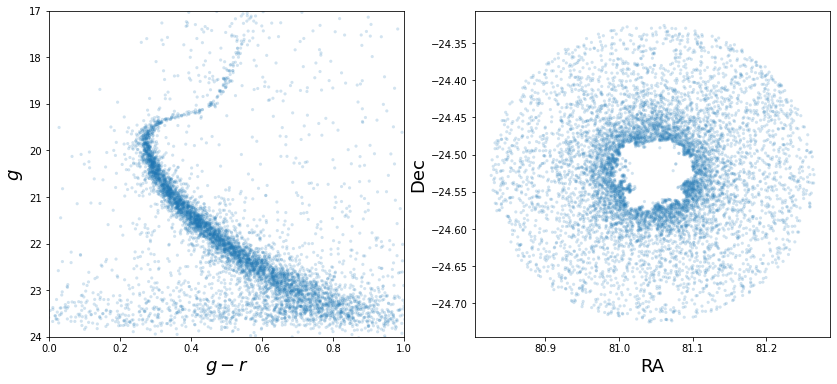

In [10]:
fig,ax = plt.subplots(1,2,figsize=(14,6))
kwargs = dict(edgecolor='none',s=10,alpha=0.2)
plt.sca(ax[0])
plt.scatter(color,mag,**kwargs)
plt.xlim(0.0,1.0)
plt.ylim(24,17)
plt.xlabel(r'$g - r$',fontsize=18)
plt.ylabel(r'$g$',fontsize=18)

plt.sca(ax[1])
plt.scatter(ra,dec,**kwargs)
plt.xlabel('RA',fontsize=18)
plt.ylabel('Dec',fontsize=18)

In [11]:
# Star/Galaxy classification based on spread_model
def extended_class(spread_model,spread_model_error):
    #taken from DES DR2 paper
    # the -9 is sentinel value
    extended_val=((spread_model + 3*spread_model_error ) > 0.005)*1
    extended_val+=((spread_model + spread_model_error ) > 0.003)*1
    extended_val+=((spread_model - spread_model_error ) > 0.003)*1
    extended_val[spread_model==-1]=-9
    return(extended_val)

In [12]:
# Define morphological classes
extclass = extended_class(gc['spread_model_r'],gc['spreaderr_model_r'])

Text(0, 0.5, 'Dec')

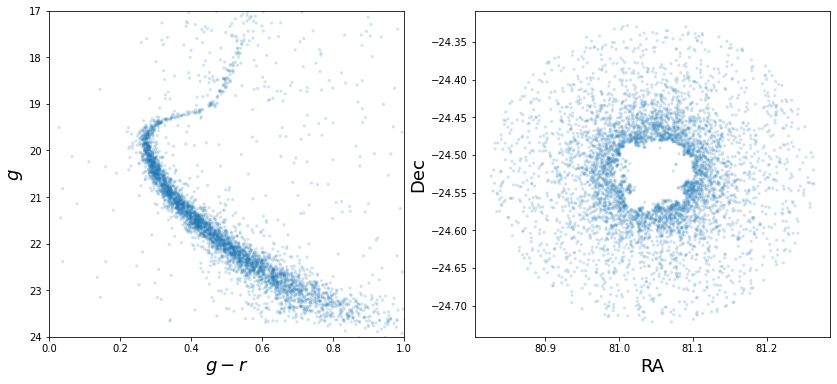

In [13]:
# Select stars
sel = (extclass == 0)

# Plot clean stars
fig,ax = plt.subplots(1,2,figsize=(14,6))
kwargs = dict(edgecolor='none',s=10,alpha=0.2)
plt.sca(ax[0])
plt.scatter(color[sel],mag[sel],**kwargs)
plt.xlim(0.0,1.0)
plt.ylim(24,17)
plt.xlabel(r'$g - r$',fontsize=18)
plt.ylabel(r'$g$',fontsize=18)

plt.sca(ax[1])
plt.scatter(ra[sel],dec[sel],**kwargs)
plt.xlabel('RA',fontsize=18)
plt.ylabel('Dec',fontsize=18)

In [14]:
# Some functions for selecting a path around the M79 isochrone

def isochrone_path(modulus=None):
    """Create a matplotlib.Path object that encloses the M79 isochrone
    
    Parameters
    ----------
    modulus : distance modulus
    
    Returns
    -------
    path : matplotlib.Path
    """
    # Distance Modulus of M79
    d0 = 12.9 #kpc
    mod0 = 5*np.log10(d0 * 1e3) - 5
    
    # Observed vertices
    vertices = np.array([
            [0.80,24.0],
            [0.70,23.5],
            [0.45,22.1],
            [0.40,21.8],
            [0.35,21.5],
            [0.30,21.0],
            [0.25,20.0],
            [0.25,19.5],
            [0.30,19.5],
            [0.30,20.0],
            [0.35,20.6],
            [0.45,21.4],
            [0.98,24.0],
            [0.80,24.0],
    ])

    # Shift the distance modulus
    if modulus is not None:
        vertices[:,1] += (modulus - mod0)

    # Return the Path object
    return Path(vertices)

def isochrone_select(color,mag,modulus=None,path=None):
    """Select stars that are inclosed by an isochrone path. 
    If path is `None`, uses the built-in M79 path.
    
    Parameters
    ----------
    color   : color (g-r)
    mag     : magnitude (g)
    modulus : distance modulus
    path    : predefined matplotlib.Path object

    Returns
    -------
    array   : boolean array indicating whether each object is contained by the path
    """

    # If path is not specified, grab M79
    if path is None:
        path = iso_path(modulus)
    # Need to reshape the points
    points = np.vstack([color,mag]).T

    # Return a boolean array for points in path
    return path.contains_points(points)

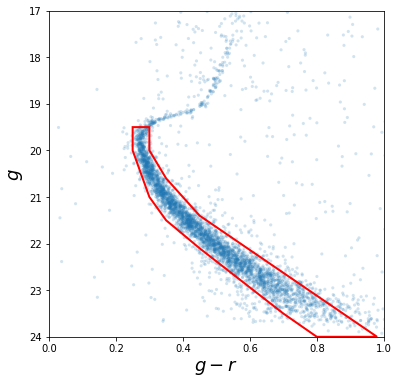

In [15]:
# Plot clean stars
fig,ax = plt.subplots(1,1,figsize=(6,6))
kwargs = dict(edgecolor='none',s=10,alpha=0.2)
plt.scatter(color[sel],mag[sel],**kwargs)
plt.xlim(0.0,1.0)
plt.ylim(24,17)
plt.xlabel(r'$g - r$',fontsize=18)
plt.ylabel(r'$g$',fontsize=18)

# Create a path around the isochrone
path = isochrone_path()
patch = PathPatch(path,facecolor='none',edgecolor='r',linewidth=2)
ax.add_artist(patch)

Text(0, 0.5, '$g$')

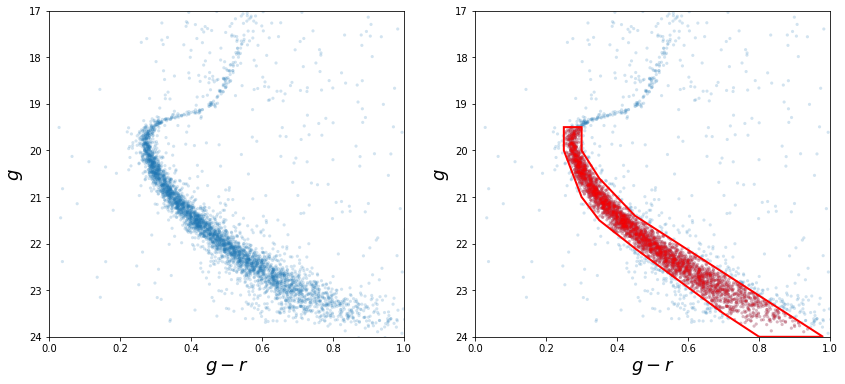

In [16]:
# Select Stars
star_sel = (extclass == 0)

# Select isochrone
path = isochrone_path()
patch = PathPatch(path,facecolor='none',edgecolor='r',linewidth=2)
iso_sel = isochrone_select(color,mag,path=path)

# Plot clean stars
fig,ax = plt.subplots(1,2,figsize=(14,6))
kwargs = dict(edgecolor='none',s=10,alpha=0.2)
plt.sca(ax[0])
plt.scatter(color[star_sel],mag[star_sel],**kwargs)
plt.xlim(0.0,1.0)
plt.ylim(24,17)
plt.xlabel(r'$g - r$',fontsize=18)
plt.ylabel(r'$g$',fontsize=18)

# Plot with isochrone selection
plt.sca(ax[1])
plt.scatter(color[star_sel],mag[star_sel],**kwargs)
plt.scatter(color[star_sel&iso_sel],mag[star_sel&iso_sel],color='r',**kwargs)
plt.gca().add_artist(patch)
plt.xlim(0.0,1.0)
plt.ylim(24,17)
plt.xlabel(r'$g - r$',fontsize=18)
plt.ylabel(r'$g$',fontsize=18)

<a class="anchor" id="atlas"></a>
# 4. Investigating the ATLAS Stellar Stream

ATLAS is a narrow stellar stream discovered by [Koposov et al. (2014)](https://arxiv.org/abs/1403.3409) in data from the ATLAS survey. DES is deeper than ATLAS, making this stream stand out prominently ([Shipp et al. 2018](https://arxiv.org/abs/1801.03097)).

In [17]:
# Define the coordinates
RA,DEC = 25, -30

# Write query statement (sql) as a string
# NOTE: triple quotes allow us to break the string on multiple lines
query = """
        SELECT ra, dec, wavg_mag_psf_g as gmag, wavg_mag_psf_r as rmag,
                   spread_model_r, spreaderr_model_r
        FROM des_dr1.main 
        WHERE q3c_radial_query(ra,dec,{0:f},{1:f},{2:f})
        AND wavg_mag_psf_g < 30 and wavg_mag_psf_r < 30
        """.format(RA,DEC,5)

# ra,dec              = celestial coordinates
# wavg_mag_psf_g,r    = Weighted average AB PSF magnitudes in DECam g,r bands
# spread_model_g,r    = star/galaxy classifier quantifying light profile relative to PSF
# spreaderr_model_g,r = uncertainty in star/galaxy classifier quantifying light profile relative to PSF
#
# WHERE: requirement that error>0 (to avoid dividing by zero) in g,r,z bands
# LIMIT: returns 200,000 rows that satisfy the query

print(query)


        SELECT ra, dec, wavg_mag_psf_g as gmag, wavg_mag_psf_r as rmag,
                   spread_model_r, spreaderr_model_r
        FROM des_dr1.main 
        WHERE q3c_radial_query(ra,dec,25.000000,-30.000000,5.000000)
        AND wavg_mag_psf_g < 30 and wavg_mag_psf_r < 30
        


In [18]:
%%time

try:
    result = qc.query(sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

# convert to pandas dataframe
atlas = helpers.utils.convert(result,'pandas')

print('Time')

Time
CPU times: user 2.71 s, sys: 1.54 s, total: 4.25 s
Wall time: 26.6 s


In [19]:
ra     = atlas['ra']
dec    = atlas['dec']
mag    = atlas['gmag']
color  = (atlas['gmag']-atlas['rmag'])

# Define morphological classes
extclass = extended_class(atlas['spread_model_r'],atlas['spreaderr_model_r'])

# Select stars
star_sel = (extclass == 0)

# Apply a magnitude limit
mag_sel = (mag < 23.5)

# Select isochrone
iso_path = isochrone_path(modulus=16.8)
iso_sel  = isochrone_select(color,mag,path=iso_path)

Text(0, 0.5, 'Dec')

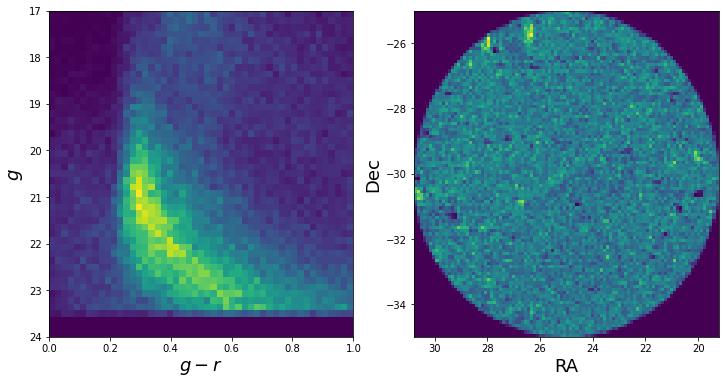

In [20]:
# Plot clean stars
sel = star_sel & mag_sel

fig,ax = plt.subplots(1,2,figsize=(12,6))
kwargs = dict(bins = [np.linspace(0,1),np.linspace(17,24)])
plt.sca(ax[0])
plt.hist2d(color[sel],mag[sel],**kwargs)
plt.xlim(0.0,1.0)
plt.ylim(24,17)
plt.xlabel(r'$g - r$',fontsize=18)
plt.ylabel(r'$g$',fontsize=18)

kwargs = dict(bins = 100)
plt.sca(ax[1])
plt.hist2d(ra[sel],dec[sel],**kwargs)
ax[1].invert_xaxis()
plt.xlabel('RA',fontsize=18)
plt.ylabel('Dec',fontsize=18)

Text(0, 0.5, 'Dec')

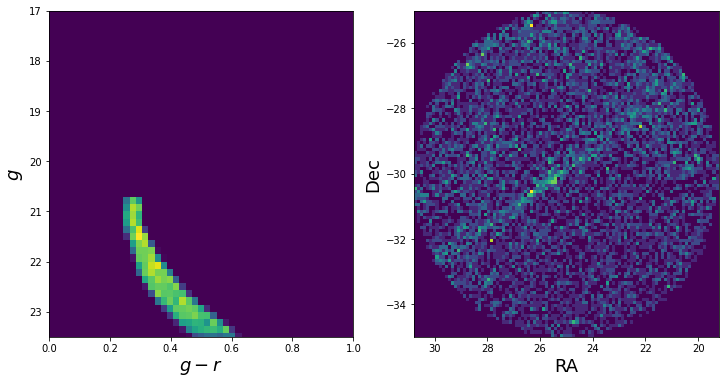

In [21]:
# Plot clean stars with isocrone filter
sel = (star_sel & mag_sel & iso_sel)

fig,ax = plt.subplots(1,2,figsize=(12,6))
kwargs = dict(bins = [np.linspace(0,1),np.linspace(17,24)])
plt.sca(ax[0])
plt.hist2d(color[sel],mag[sel],**kwargs)
plt.xlim(0.0,1.0)
plt.ylim(23.5,17)
plt.xlabel(r'$g - r$',fontsize=18)
plt.ylabel(r'$g$',fontsize=18)

kwargs = dict(bins = 100)
plt.sca(ax[1])
plt.hist2d(ra[sel],dec[sel],**kwargs)
ax[1].invert_xaxis()
plt.xlabel('RA',fontsize=18)
plt.ylabel('Dec',fontsize=18)

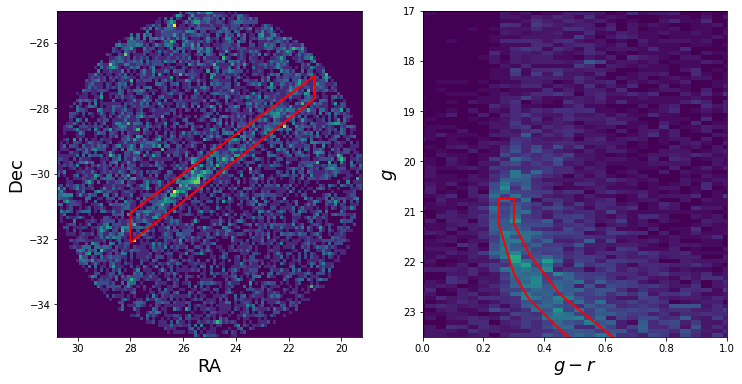

In [22]:
# Define the track of the stream, then examine its CMD
sel = (star_sel & mag_sel & iso_sel)

fig,ax = plt.subplots(1,2,figsize=(12,6))
kwargs = dict(bins = [np.linspace(0,1),np.linspace(17,24)])

kwargs = dict(bins = 100)
plt.sca(ax[0])
plt.hist2d(ra[sel],dec[sel],**kwargs)
plt.gca().invert_xaxis()
plt.xlabel('RA',fontsize=18)
plt.ylabel('Dec',fontsize=18)

# Define the stream track
vertices = np.array([
      [28,-32.1],
      [28,-31.2],
      [21,-27.0],
      [21,-27.7],
      [28,-32.1]
])
path = Path(vertices)
plt.gca().add_artist(PathPatch(path,facecolor='none',edgecolor='r',linewidth=2))

# Select stars that reside close to the stream
points = np.vstack([ra,dec]).T
track_sel = path.contains_points(points)

sel = (star_sel & mag_sel & track_sel)

# Plot the CMD of stars that are spatially coincident with the stream
plt.sca(ax[1])
plt.hist2d(color[sel],mag[sel],**kwargs)
plt.xlim(0.0,1.0)
plt.ylim(23.5,17)
plt.xlabel(r'$g - r$',fontsize=18)
plt.ylabel(r'$g$',fontsize=18)
plt.gca().add_artist(PathPatch(iso_path,facecolor='none',edgecolor='r',linewidth=2))

<a class="anchor" id="refrences"></a>
# References

* [DES Collaboration (2018) "The Dark Energy Survey Data Release 1"](https://arxiv.org/abs/1801.03181)
* [DES Collaboration (2021) "The Dark Energy Survey Data Release 2"]()
* [Flaugher et al. (2015) "The Dark Energy Camera"](https://arxiv.org/abs/1504.02900)
* [Koposov et al. (2014) "Discovery of a cold stellar stream in the ATLAS DR1 data"](https://arxiv.org/abs/1403.3409)
* [Shipp et al. (2018) "Stellar Streams Discovered in the Dark Energy Survey"](https://arxiv.org/abs/1801.03097)